In [1]:
import os
import torch
from diffusers import DiffusionPipeline, UNet2DConditionModel, StableDiffusionPipeline
from peft import LoraConfig, get_peft_model, PeftModel
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Device Configuration
if torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = "cpu"
    dtype = torch.float32
    print("Using CPU. Note: Generation will be slow.")


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Using GPU: Tesla T4


# **[First: run Part2:S2 Stable Diffusion Inference](https://drive.google.com/file/d/1KdGC1izz1nqdUzCqROOiZBEfiznWBvkf/view?usp=sharing)**

### Local environment setup - no drive mount needed


In [2]:
model_path = "./sd15_local"
model_id = "runwayml/stable-diffusion-v1-5"

if not os.path.exists(model_path):
    print(f"Downloading model '{model_id}' ...")
    pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
    pipe.save_pretrained(model_path)
    print(f"Model saved to {model_path}")
else:
    print(f"Loading model from {model_path} ...")
    pipe = DiffusionPipeline.from_pretrained(model_path, torch_dtype=dtype)

pipe = pipe.to(device)
unet = pipe.unet
unet.requires_grad_(False)   # Freeze base UNet

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to ./sd15_local


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

# LoRA Example Using a 28×28 Image

## 1) Input Image as a Vector

A grayscale MNIST image has size **28 × 28**.

We flatten it into a vector:

x ∈ ℝ⁷⁸⁴

That means the image is now represented as **784 numerical pixel values**.

---
## 2) A Normal Linear Layer (Without LoRA)

Suppose we have a linear layer that maps the image vector into **128 features**:

y = W₀ x

Where:

W₀ ∈ ℝ¹²⁸ˣ⁷⁸⁴

### Number of trainable parameters (Full Fine-Tuning)

128 × 784 = **100,352 parameters**

If we fine-tune normally, we must update **all 100,352 weights**.

---
## 3) Adding LoRA to the Same Layer

So far, we have a normal linear layer with a large weight matrix W₀.  
If we fine-tune this layer in the usual way, we must update **all** its weights — which is expensive in memory and slow for large models.

The goal of **LoRA (Low-Rank Adaptation)** is to solve this problem:

> **How can we adapt a large pretrained model to a new task, without updating all its weights?**

Instead of modifying W₀ directly, LoRA keeps W₀ **frozen** and adds a small trainable update on top of it.  
This lets us change the model’s behavior with only a tiny number of new parameters.

Mathematically, LoRA adds a low-rank update to the original weight matrix:
W = W₀ + BA

LoRA modifies the layer as:

- y = (W₀ + BA)
- x = W₀x + B(Ax)

We keep W₀ **frozen**, and only train A and B.

We choose a small rank:

r = 4

So:

A ∈ ℝ⁴ˣ⁷⁸⁴
B ∈ ℝ¹²⁸ˣ⁴

## 3.0) What do A and B represent?

LoRA does not change the original weight matrix W₀.  
Instead, it adds a **low-rank adaptation**:

ΔW = BA

### A — The Compressor

• Takes the high-dimensional input (784 features)  
• Compresses it into a small space of size r (rank)  
• Learns **which input directions are important to adjust**

### B — The Expander

• Takes the small r-dimensional vector  
• Expands it back to 128 output features  
• Learns **how to apply the adjustment to the output**

### Together

Ax → Compression  
B(Ax) → Re-expansion  

So the final layer becomes:

y = W₀x + B(Ax)

• W₀x keeps the original model knowledge  
• B(Ax) adds a small learned change


## 3.1) How do A and B learn?

A and B are new trainable weight matrices.  
They are initialized randomly at the start of fine-tuning.

During training:

1) We pass data through the layer  
2) Compute the loss  
3) Run backpropagation

Key rule:

• W₀ is frozen (no updates)  
• Only A and B receive gradients

So the optimizer updates:

A ← A − η ∇A  
B ← B − η ∇B

While W₀ remains unchanged.

After training:

• A learns **what to change**  
• B learns **how to apply the change**

---
## 4) Trainable Parameters with LoRA

Number of parameters to train:

- A: 4 × 784 = 3,136

- B: 128 × 4 = 512

Total = **3,648 parameters**

---
## 5) Parameter Savings

| Method | Trainable Parameters |
|--------|----------------------|
| Full Fine-Tuning | 100,352 |
| LoRA (r = 4) | 3,648 |

LoRA trains **~27× fewer parameters** in this single layer.

---
## 6) What Happens During Forward Pass

Instead of computing only:

y = W₀x

We compute:

y = W₀x + B(Ax)

• W₀x keeps the original knowledge
• B(Ax) adds a small learned adjustment

This small adjustment is enough to change the model’s behavior toward a new style or task.

---
## 7) Key Takeaway

**LoRA allows us to adapt a large model by training only a tiny number of additional parameters, while keeping the original model fully intact.**

In [3]:
lora_config = LoraConfig(
    r=4, # style
    lora_alpha=16, # 16 / 4 = 4
    target_modules=["to_q","to_k","to_v","to_out.0"], #
    lora_dropout=0.1,
    bias="none"
)

unet = get_peft_model(unet, lora_config) #  Parameter-Efficient Fine-Tuning.
unet.print_trainable_parameters()


trainable params: 797,184 || all params: 860,318,148 || trainable%: 0.0927


## 8) Where do we insert LoRA inside Stable Diffusion?

Stable Diffusion is a large model, but the **core component that controls image generation** is the **UNet**.

Inside the UNet, the most important part is the **Attention Layers**.
These layers decide **how the text prompt influences the image features**.

So, if we want to change the model’s style or behavior,
the smartest place to adapt is **the attention mechanism** — not the whole network.

---

### Why Attention Layers?

During generation:

• The text prompt is converted into text embeddings
• The UNet processes noisy image latents
• **Cross-Attention layers connect text and image**

This means attention layers answer the question:

> “Which words in the prompt should influence which parts of the image?”

So, modifying attention layers = modifying **how the model understands and applies text guidance**.

---

### Which parts of Attention do we target?

Each attention layer contains four key projection matrices:

• **to_q** → creates Query vectors
• **to_k** → creates Key vectors
• **to_v** → creates Value vectors
• **to_out** → projects attention output back to the network

These matrices control **how information flows inside attention**.

Therefore, in LoRA we insert adapters into:

```
to_q, to_k, to_v, to_out
```

---

### Why not modify everything?

Because:

• UNet has hundreds of millions of parameters
• Most knowledge (shapes, objects, composition) is already correct
• We only want to **slightly adjust behavior or style**

LoRA adds small low-rank updates **only inside attention**,
giving maximum effect with minimal new parameters.

---

### A simple example

Prompt:

> "A handwritten word on a white background"

Before LoRA (Base Model):

• The attention layers focus on the word *"handwritten"*
• The model produces **generic handwriting style**

After LoRA trained on MNIST:

• LoRA slightly changes the attention projections
• The model now focuses more on **digit-like strokes**
• The output becomes **MNIST-style handwriting**

So, LoRA did not change the whole UNet —
It only changed **how attention connects text to image features**.

---
> **LoRA is inserted into the attention projection layers of the UNet, because attention is where text controls image generation.**


In [4]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),  # <-- add this RGB وهمي
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


In [5]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4) # AdamW = ِadam + Weight decay
vae = pipe.vae
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer
scheduler = pipe.scheduler

unet.train()

PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Linear(in_feat


## The Core Idea — What Are We Really Teaching?

In this project, our objective is **not** to teach the model:
- What each digit means (0, 1, 2, …)
- Or how to recognize numbers linguistically

Instead, our objective is:

> **To teach the model the MNIST handwriting style.**

All MNIST images share the same visual identity:
- Stroke thickness
- Curve shapes
- Writing consistency

So we only need **one shared textual identity** to represent this style.

---

## Why Not Use "zero", "one", "two", ... ?

If we used different prompts per image:

```
"zero", "one", "two", ...
```

The model would need to learn:
- The shape of each digit
- The meaning of each word
- The mapping between word and image

That means:
- More complexity
- Longer training
- Larger model capacity

But this is **not our goal**.

---

## Why Using One Prompt Works

By assigning the same prompt:

```
"digit"
```

to **all** images, we tell the model:

> “Everything paired with the word *digit* represents one visual style.”

So the model learns:
- A single text embedding for "digit"
- Strong association with MNIST handwriting style
- No concern about number identity

This is exactly what we want.

---

## How CLIP is Used in the Code

These two lines represent **CLIP**

```python
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
```

### ✅ `pipe.tokenizer`
This is the **CLIP Tokenizer**  
It converts the text prompt into tokens (numbers).

### ✅ `pipe.text_encoder`
This is the **CLIP Text Encoder**  
It converts tokens into **Text Embeddings** (numerical meaning vectors).

Together, they form the **CLIP Text Model**.


During training, every image batch is paired with the **same text prompt**:

```
"digit"
```
## CLIP Tokenization and Text Embedding

```python
tokens = tokenizer(
    ["digit"] * images.size(0),   # Repeat "digit" for the whole batch
    padding="max_length",
    max_length=77,
    return_tensors="pt"
).input_ids.to("cuda")

text_emb = text_encoder(tokens)[0]
```

CLIP converts this text into a numerical embedding.
This embedding becomes the **style condition** for the diffusion model.

---

## What Happens Here? (Step-by-Step)

1. `["digit"] * images.size(0)`  
   Every image in the batch receives the same prompt.

2. `tokenizer(...)`  
   Converts the word "digit" into CLIP tokens.

3. `text_encoder(tokens)`  
   Produces a high-dimensional text embedding.

4. `text_emb`  
   Represents **the MNIST handwriting style** in vector form.

This embedding is later injected into the diffusion U-Net through cross-attention.

---

In [6]:
for step, (images, labels) in enumerate(train_loader):
    if step > 500: break   # تدريب سريع للتجربة

    images = images.to(device, dtype=dtype)

    # Encode images to latent space
    latents = vae.encode(images).latent_dist.sample() * 0.18215

    # Dummy text prompt
    tokens = tokenizer(["digit"] * images.size(0),
                        padding="max_length",
                        max_length=77,
                        return_tensors="pt").input_ids.to(device)

    text_emb = text_encoder(tokens)[0]

    # Add noise
    noise = torch.randn_like(latents)
    timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.size(0),), device=device).long()
    noisy_latents = scheduler.add_noise(latents, noise, timesteps)

    # Predict noise
    noise_pred = unet(noisy_latents, timesteps, text_emb).sample

    loss = F.mse_loss(noise_pred, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print("Step:", step, "Loss:", loss.item())

Step: 0 Loss: 0.0267333984375
Step: 50 Loss: 0.01271820068359375
Step: 100 Loss: 0.00951385498046875
Step: 150 Loss: 0.047027587890625
Step: 200 Loss: 0.018768310546875
Step: 250 Loss: 0.01947021484375
Step: 300 Loss: 0.0061187744140625
Step: 350 Loss: 0.006214141845703125
Step: 400 Loss: 0.007656097412109375
Step: 450 Loss: 0.0033397674560546875
Step: 500 Loss: 0.016204833984375


In [7]:
# Path where LoRA will be saved
save_path = "./mnist_sd_lora_digit"

# Save unet = LoRA adapter
unet.save_pretrained(save_path)

print("✅ LoRA Saved locally!")
print("📂 Location:", save_path)

✅ LoRA Saved locally!
📂 Location: ./mnist_sd_lora_digit


In [8]:
# ============================================
# 2: Load Stable Diffusion + Attach LoRA
# ============================================

import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel

model_path = "./sd15_local"

# Load base Stable Diffusion
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=dtype
).to(device)

# Path to LoRA locally
lora_path = "./mnist_sd_lora_digit"

# Attach LoRA to UNet
pipe.unet = PeftModel.from_pretrained(pipe.unet, lora_path)

print("✅ LoRA Loaded Locally!")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

✅ LoRA Loaded Locally!


In [9]:
# ============================================
# 3: Load Base Stable Diffusion (No LoRA)
# ============================================

pipe_base = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=dtype
).to(device)

print("✅ Base Stable Diffusion Loaded!")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

✅ Base Stable Diffusion Loaded!


In [10]:
# ============================================
# Cell 4: Define Prompt
# ============================================

prompt = """
A hand-drawn of a cat, black ink on white background, minimal line art, MNIST handwriting style
"""

  0%|          | 0/100 [00:00<?, ?it/s]

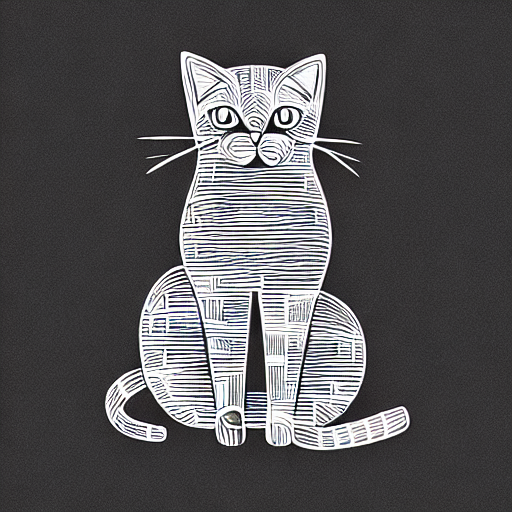

In [11]:
# ============================================
# 5: Inference with Stable Diffusion + LoRA
# ============================================

image_lora = pipe(
    prompt,
    num_inference_steps=100,
    guidance_scale=9,
    generator=torch.manual_seed(500)
).images[0]

image_lora

  0%|          | 0/100 [00:00<?, ?it/s]

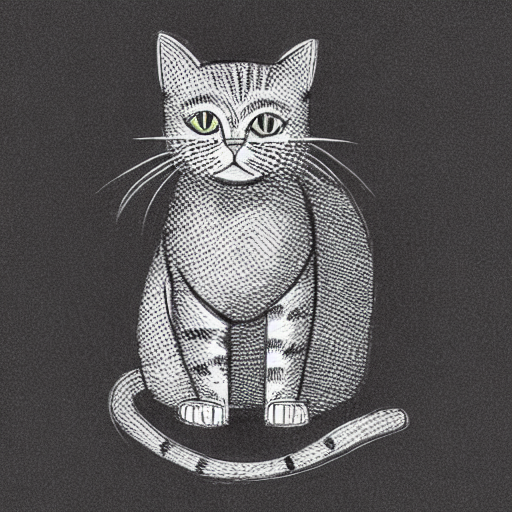

In [12]:
# ============================================
#  6: Inference with Base Stable Diffusion
# ============================================

image_base = pipe_base(
    prompt,
    num_inference_steps=100,
    guidance_scale=9,
    generator=torch.manual_seed(500)
).images[0]

image_base

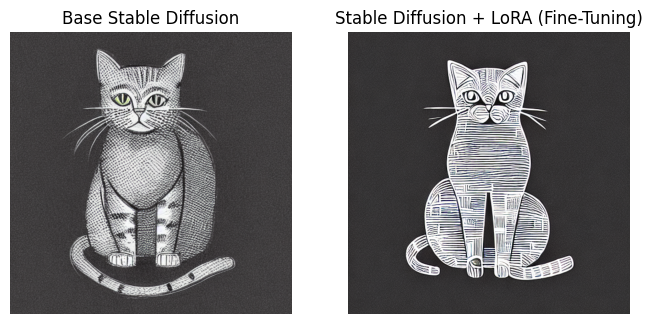

In [13]:
# ============================================
#  7: Visual Comparison
# ============================================

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(image_base)
plt.title("Base Stable Diffusion")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image_lora)
plt.title("Stable Diffusion + LoRA (Fine-Tuning)")
plt.axis("off")

plt.show()


| Aspect | Base Stable Diffusion | Stable Diffusion + LoRA |
|--------|----------------------|--------------------------|
| Writing style | Generic handwriting | MNIST-like handwriting |
| Stroke thickness | Smooth / thin strokes | Thicker, marker-like strokes |
| Digit clarity | Weak / unclear digit form | Clearer digit-like structure |
| Training effect | No adaptation | Visible LoRA adaptation |


## Hands‑On Lab: Controlling LoRA Behavior

In this section, you will interact with LoRA in a controlled and safe way.
You will not modify the model architecture or core training logic.

The objective is to understand how small, intentional controls influence model behavior.

---

## Task 1 — Adjust LoRA Strength (Inference Control)

### Goal
Understand how LoRA influence strength affects image generation during inference.
LoRA does not replace the base model.
It adds a controllable adaptation layer on top of it.
---

### What You Will Modify
You will adjust the LoRA scale during inference.

This value controls how strongly the LoRA adapters influence the UNet attention layers.

### What to Observe
Generate images using the same prompt and random seed.

Compare the results:

- 0.3: very subtle style influence
- 1.0: balanced LoRA effect
- 1.5: strong and exaggerated style

Focus your comparison on:
- Stroke thickness
- Line roughness
- Overall visual identity

### Reflection Question
Why does changing the LoRA scale affect the output, even though the base UNet weights remain unchanged?

---


Generating with LoRA Scale: 0.0...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with LoRA Scale: 0.3...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with LoRA Scale: 1.0...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with LoRA Scale: 1.5...


  0%|          | 0/50 [00:00<?, ?it/s]

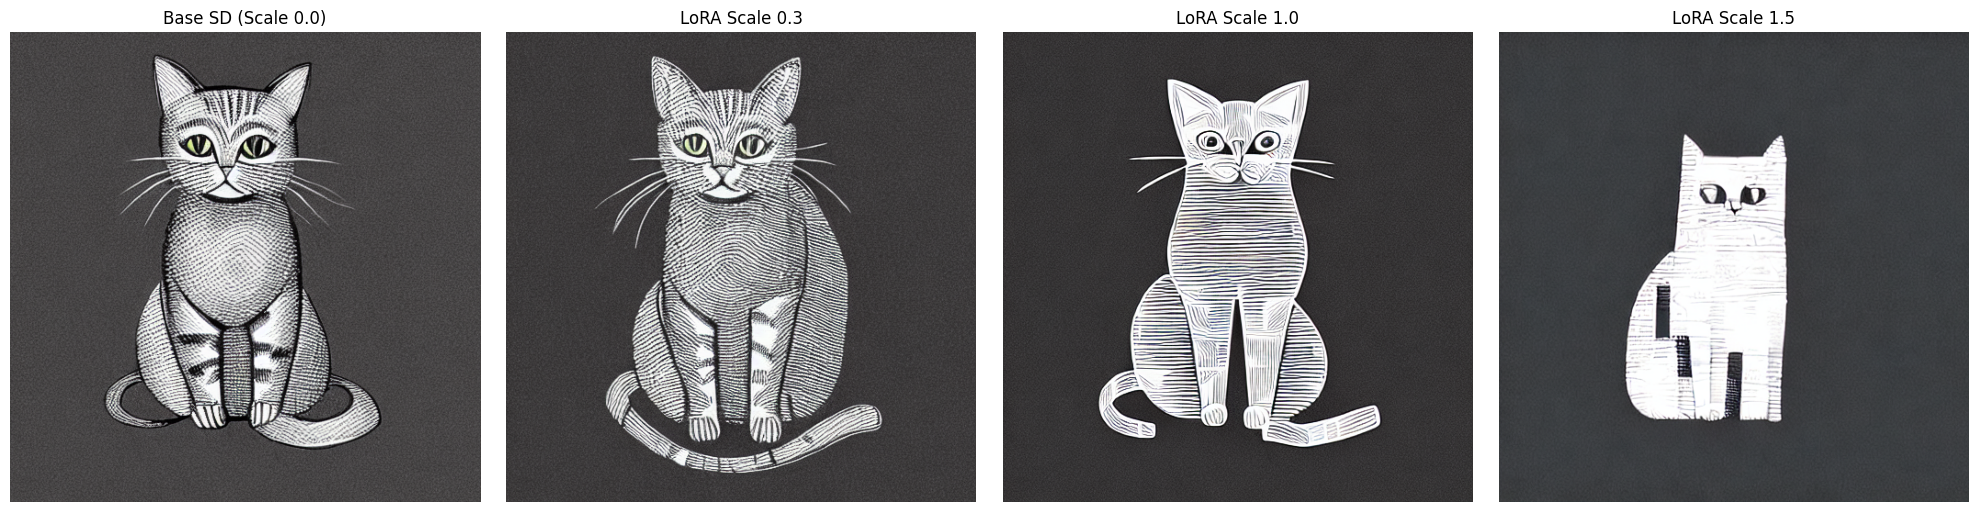

In [14]:
import torch
import matplotlib.pyplot as plt

# Prompt
test_prompt = (
    "A hand-drawn of a cat, black ink on white background, "
    "minimal line art, MNIST handwriting style"
)

# LoRA scales
scales = [0.0, 0.3, 1.0, 1.5]
results = []

for s in scales:
    print(f"Generating with LoRA Scale: {s}...")

    img = pipe(
        test_prompt,
        num_inference_steps=50,
        guidance_scale=9,
        cross_attention_kwargs={"scale": s},  # ✅ CORRECT CONTROL
        generator=torch.manual_seed(500)
    ).images[0]

    results.append(img)

# Visualization
fig, axs = plt.subplots(1, len(results), figsize=(20, 5))

titles = [
    "Base SD (Scale 0.0)",
    "LoRA Scale 0.3",
    "LoRA Scale 1.0",
    "LoRA Scale 1.5"
]

for i, img in enumerate(results):
    axs[i].imshow(img)
    axs[i].set_title(titles[i])
    axs[i].axis("off")

plt.tight_layout()
plt.show()


Generating with LoRA scale = 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with LoRA scale = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating with LoRA scale = 2.0


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating with LoRA scale = 3.0


  0%|          | 0/50 [00:00<?, ?it/s]

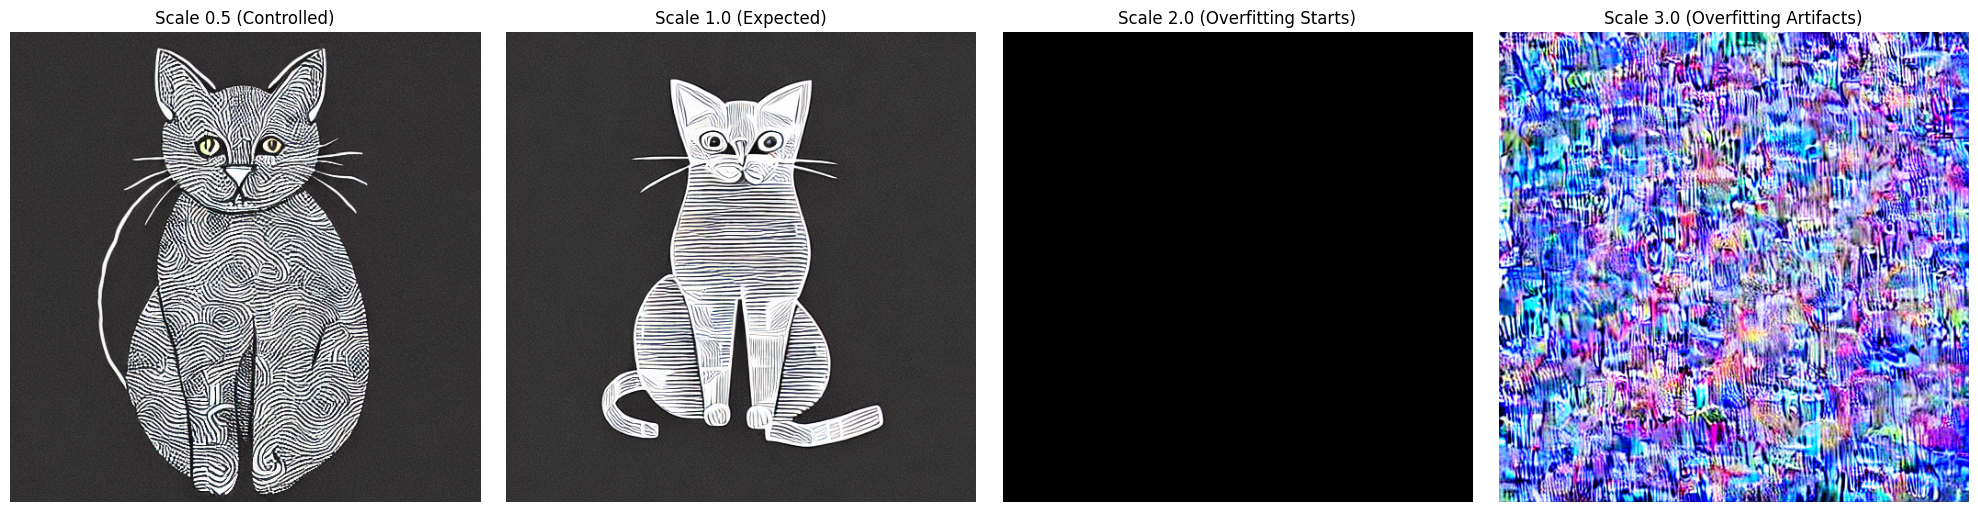

In [15]:
import torch
import matplotlib.pyplot as plt

test_prompt = (
    "A hand-drawn of a cat, black ink on white background, "
    "minimal line art, MNIST handwriting style"
)

# Push scale beyond normal range
scales = [0.5, 1.0, 2.0, 3.0]
results = []

for s in scales:
    print(f"Generating with LoRA scale = {s}")

    img = pipe(
        test_prompt,
        num_inference_steps=50,
        guidance_scale=9,
        cross_attention_kwargs={"scale": s},
        generator=torch.manual_seed(500)
    ).images[0]

    results.append(img)

# Visualization
fig, axs = plt.subplots(1, len(results), figsize=(20, 5))

titles = [
    "Scale 0.5 (Controlled)",
    "Scale 1.0 (Expected)",
    "Scale 2.0 (Overfitting Starts)",
    "Scale 3.0 (Overfitting Artifacts)"
]

for i, img in enumerate(results):
    axs[i].imshow(img)
    axs[i].set_title(titles[i])
    axs[i].axis("off")

plt.tight_layout()
plt.show()


## Task 2 — Modify the Training Prompt (Style Control)

### Goal
Understand how the training text prompt defines what LoRA learns.

You will keep the dataset, model, and training settings unchanged.
Only the training prompt will be modified.

---

### What You Will Modify

During training, the current prompt is:

```
"digit"
```

Replace it of the following options:

- "handwritten digit"
- "simple sketch style"
- "child handwriting"

---

### Where to Edit (Code Hint)

Locate the following line inside the training loop:

```
tokens = tokenizer(["digit"] * images.size(0),
                    padding="max_length",
                    max_length=77,
                    return_tensors="pt").input_ids.to("cuda")
```

Replace the string "digit" with your chosen prompt.

---

### Training Instructions

- Train for 200–300 steps only
- Do not change:
  - LoRA rank
  - Learning rate
  - Dataset
  - Target UNet layers

---

### Inference and Comparison

After training:

- Run inference using the same generation prompt as before
- Compare outputs from:
  - Base Stable Diffusion
  - Stable Diffusion with LoRA

Observe differences in:
- Line style
- Visual consistency
- Handwriting characteristics

---

### Reflection Question
Did LoRA learn what the object is, or how the object should look?


In [ ]:
import torch
import torch.nn.functional as F
import random
from diffusers import StableDiffusionPipeline
from peft import PeftModel

# ============================================
# Settings
# ============================================

device = "cuda"
dtype = torch.float16

styles = [
    "handwritten digit",
    "simple sketch style",
    "child handwriting"
]

max_steps = 500
save_path = "./mnist_sd_lora_multi_style"
model_path = "./sd15_local"

# ============================================
# Assumes you already loaded:
# tokenizer
# text_encoder
# vae
# unet (LoRA attached)
# optimizer
# scheduler
# train_loader
# ============================================

unet.train()

global_step = 0

# ============================================
# TRAINING LOOP
# ============================================

for step, (images, labels) in enumerate(train_loader):

    if global_step >= max_steps:
        break

    images = images.to(device, dtype=dtype)

    # Randomly choose style (better than looping)
    style = random.choice(styles)

    # -----------------------------
    # Encode Images → Latents
    # -----------------------------
    with torch.no_grad():
        latents = vae.encode(images).latent_dist.sample()
        latents = latents * 0.18215

    # -----------------------------
    # Add Noise
    # -----------------------------
    noise = torch.randn_like(latents)

    timesteps = torch.randint(
        0,
        scheduler.config.num_train_timesteps,
        (latents.size(0),),
        device=device
    ).long()

    noisy_latents = scheduler.add_noise(latents, noise, timesteps)

    # -----------------------------
    # Text Conditioning
    # -----------------------------
    with torch.no_grad():
        tokens = tokenizer(
            [style] * images.size(0),
            padding="max_length",
            max_length=77,
            return_tensors="pt"
        ).input_ids.to(device)

        text_emb = text_encoder(tokens)[0]

    # -----------------------------
    # UNet Forward
    # -----------------------------
    noise_pred = unet(noisy_latents, timesteps, text_emb).sample

    loss = F.mse_loss(noise_pred, noise)

    # -----------------------------
    # Backprop
    # -----------------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    global_step += 1

    if global_step % 50 == 0:
        print(f"Step {global_step} | Style: {style} | Loss: {loss.item():.4f}")

# ============================================
# SAVE LoRA
# ============================================

unet.save_pretrained(save_path)

print("✅ LoRA Saved!")
print("📂 Path:", save_path)

# ============================================
# LOAD PIPELINE WITH LoRA
# ============================================

pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=dtype
).to(device)

pipe.unet = PeftModel.from_pretrained(pipe.unet, save_path)

print("✅ LoRA Loaded!")

# ============================================
# LOAD BASE MODEL (NO LoRA)
# ============================================

pipe_base = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=dtype
).to(device)

print("✅ Base Model Loaded!")

# ============================================
# INFERENCE TEST
# ============================================

prompt = "a digit number 5, handwritten digit"

generator = torch.manual_seed(500)

image_lora = pipe(
    prompt,
    num_inference_steps=100,
    guidance_scale=9,
    generator=generator
).images[0]

generator = torch.manual_seed(500)

image_base = pipe_base(
    prompt,
    num_inference_steps=100,
    guidance_scale=9,
    generator=generator
).images[0]

# ============================================
# Show Results
# ============================================

image_lora, image_base


Step 50 | Style: child handwriting | Loss: 0.0118
Step 100 | Style: child handwriting | Loss: 0.0199
Step 150 | Style: handwritten digit | Loss: 0.0693
Step 200 | Style: child handwriting | Loss: 0.0112
Step 250 | Style: child handwriting | Loss: 0.0297
Step 300 | Style: simple sketch style | Loss: 0.0107


In [ ]:
import torch
import torch.nn.functional as F
import random
from diffusers import StableDiffusionPipeline
from peft import PeftModel

# ============================================
# Settings
# ============================================
device = "cuda"
dtype = torch.float16

styles = [
    "handwritten digit",
    "simple sketch style",
    "child handwriting"
]

max_steps = 500
save_path = "./mnist_sd_lora_multi_style"
model_path = "./sd15_local"

# ============================================
# Assume These Are Already Loaded
# ============================================
# pipe components from base SD
# tokenizer
# text_encoder
# vae
# unet
# scheduler
# optimizer
# train_loader

unet.train()

global_step = 0

# ============================================
# LoRA Training
# ============================================

for step, (images, labels) in enumerate(train_loader):

    if global_step > max_steps:
        break

    images = images.to(device, dtype=dtype)

    # randomly pick style each iteration (better balance)
    style = random.choice(styles)

    # ----------------------------------------
    # Encode Images → Latents
    # ----------------------------------------
    latents = vae.encode(images).latent_dist.sample()
    latents = latents * 0.18215

    # ----------------------------------------
    # Add Noise
    # ----------------------------------------
    noise = torch.randn_like(latents)

    timesteps = torch.randint(
        0,
        scheduler.config.num_train_timesteps,
        (latents.size(0),),
        device=device
    ).long()

    noisy_latents = scheduler.add_noise(latents, noise, timesteps)

    # ----------------------------------------
    # Text Conditioning
    # ----------------------------------------
    tokens = tokenizer(
        [style] * images.size(0),
        padding="max_length",
        max_length=77,
        return_tensors="pt"
    ).input_ids.to(device)

    text_emb = text_encoder(tokens)[0]

    # ----------------------------------------
    # Predict Noise
    # ----------------------------------------
    noise_pred = unet(noisy_latents, timesteps, text_emb).sample

    loss = F.mse_loss(noise_pred, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    global_step += 1

    if global_step % 50 == 0:
        print(f"Step {global_step} | Style: {style} | Loss: {loss.item():.4f}")

# ============================================
# Save LoRA
# ============================================

unet.save_pretrained(save_path)

print("✅ LoRA Saved!")
print("📂 Path:", save_path)

# ============================================
# Load Stable Diffusion + LoRA
# ============================================

pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=dtype
).to(device)

pipe.unet = PeftModel.from_pretrained(pipe.unet, save_path)

print("✅ LoRA Loaded!")

# ============================================
# Load Base Stable Diffusion (No LoRA)
# ============================================

pipe_base = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=dtype
).to(device)

print("✅ Base Model Loaded!")

# ============================================
# Inference Comparison
# ============================================

prompt = "a digit number 5, handwritten digit"

generator = torch.manual_seed(500)

image_lora = pipe(
    prompt,
    num_inference_steps=100,
    guidance_scale=9,
    generator=generator
).images[0]

generator = torch.manual_seed(500)

image_base = pipe_base(
    prompt,
    num_inference_steps=100,
    guidance_scale=9,
    generator=generator
).images[0]

# show results (if using notebook)
image_lora, image_base


---

## Task 3 — Conceptual Understanding (No Code)

Answer the following questions clearly and concisely:

1. Why are the original UNet weights frozen during LoRA training?
2. Why is LoRA effective for style adaptation but not for learning new concepts?
3. Why was a single shared training prompt used for all MNIST images?
4. What issue might arise if training prompts such as "zero", "one", and "two" were used?

1. Why are the original UNet weights frozen during LoRA training?
Freezing the UNet preserves the general visual knowledge learned during large-scale pretraining and avoids catastrophic forgetting. LoRA adds small, controlled updates without overwriting the base model.

2. Why is LoRA effective for style adaptation but not for learning new concepts?
Style mainly affects how features are rendered (edges, strokes, textures), which can be adjusted through low-rank attention updates. New concepts require deeper semantic changes that LoRA cannot represent.

3. Why was a single shared training prompt used for all MNIST images?
Using one shared prompt forces the LoRA to learn a consistent visual style instead of memorizing digit-specific meanings.

4. What issue might arise if prompts like "zero", "one", and "two" were used?
The LoRA could unintentionally learn digit identity rather than style, mixing content learning with style adaptation and reducing generalization.